# Load Libraries

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load dataset

In [2]:
# Load dataset
df = pd.read_csv("Myocardial infarction complications Database.csv")

# Exploratory Data Analysis (EDA)

In [3]:
# Basic overview
print("Head of the dataset:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nSummary statistics:")
print(df.describe())

Head of the dataset:
   ID   AGE  SEX  INF_ANAM  STENOK_AN  FK_STENOK  IBS_POST  IBS_NASL   GB  \
0   1  77.0    1       2.0        1.0        1.0       2.0       NaN  3.0   
1   2  55.0    1       1.0        0.0        0.0       0.0       0.0  0.0   
2   3  52.0    1       0.0        0.0        0.0       2.0       NaN  2.0   
3   4  68.0    0       0.0        0.0        0.0       2.0       NaN  2.0   
4   5  60.0    1       0.0        0.0        0.0       2.0       NaN  3.0   

   SIM_GIPERT  ...  JELUD_TAH  FIBR_JELUD  A_V_BLOK  OTEK_LANC  RAZRIV  \
0         0.0  ...          0           0         0          0       0   
1         0.0  ...          0           0         0          0       0   
2         0.0  ...          0           0         0          0       0   
3         0.0  ...          0           0         0          0       0   
4         0.0  ...          0           0         0          0       0   

   DRESSLER  ZSN  REC_IM  P_IM_STEN  LET_IS  
0         0    0       0 


Class distribution in 'LET_IS':
LET_IS
0    1429
1     110
3      54
7      27
6      27
4      23
2      18
5      12
Name: count, dtype: int64


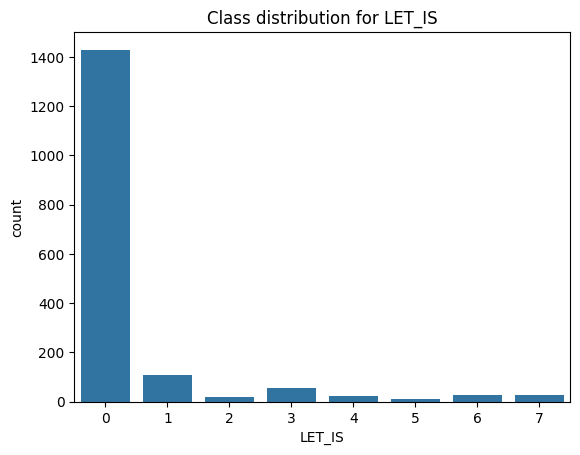

In [4]:
# Convert categorical columns
categorical_cols = ['SEX', 'INF_ANAM', 'STENOK_AN', 'IBS_POST', 'SIM_GIPERT']
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Check for class imbalance for a target column, e.g., 'LET_IS' (assuming it's target)
if 'LET_IS' in df.columns:
    print("\nClass distribution in 'LET_IS':")
    print(df['LET_IS'].value_counts())
    sns.countplot(x='LET_IS', data=df)
    plt.title("Class distribution for LET_IS")
    plt.show()

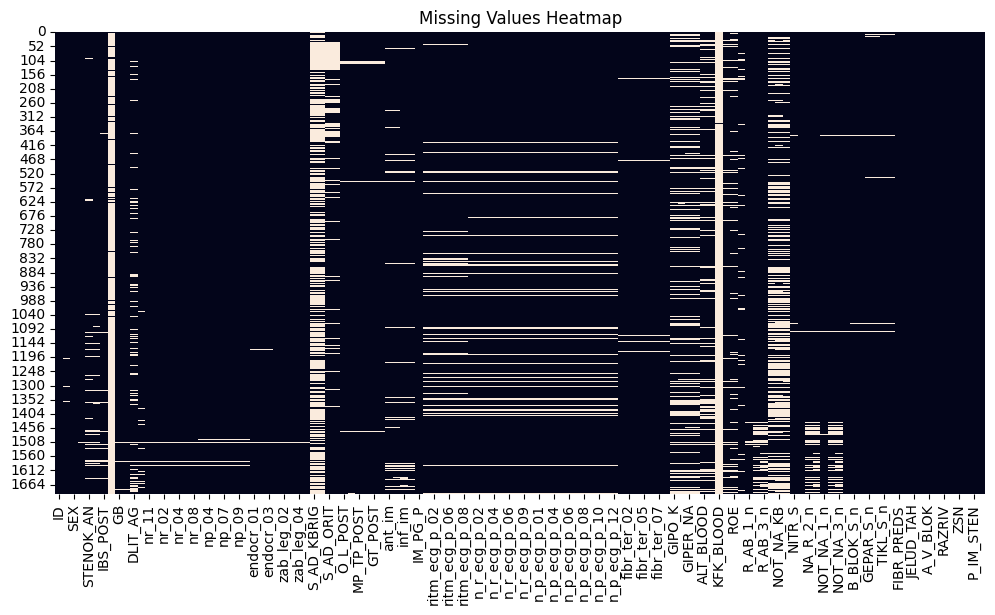

In [5]:
# Visualize missing data heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

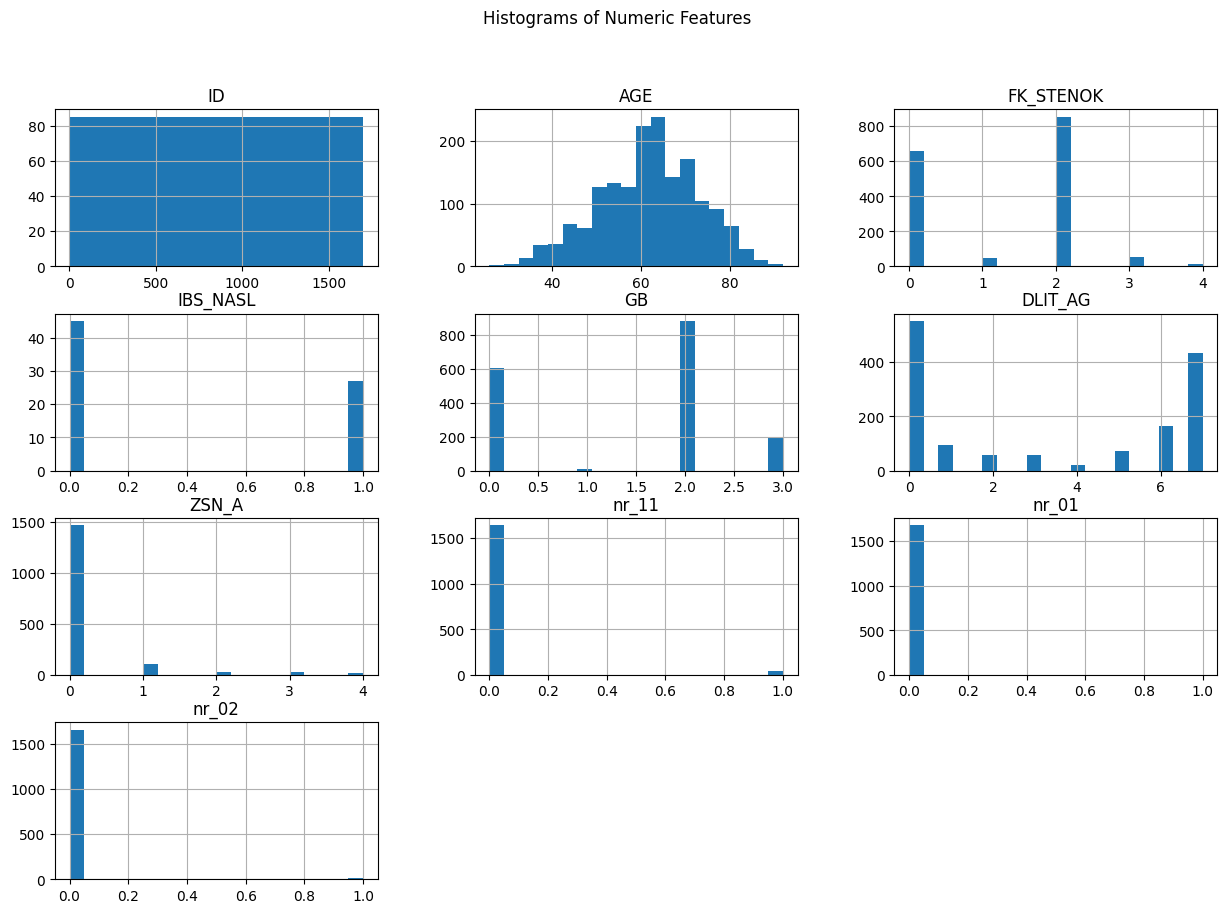

In [6]:
# Histograms for numeric columns (first 10 numeric columns for brevity)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns[:10]
df[num_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle("Histograms of Numeric Features")
plt.show()

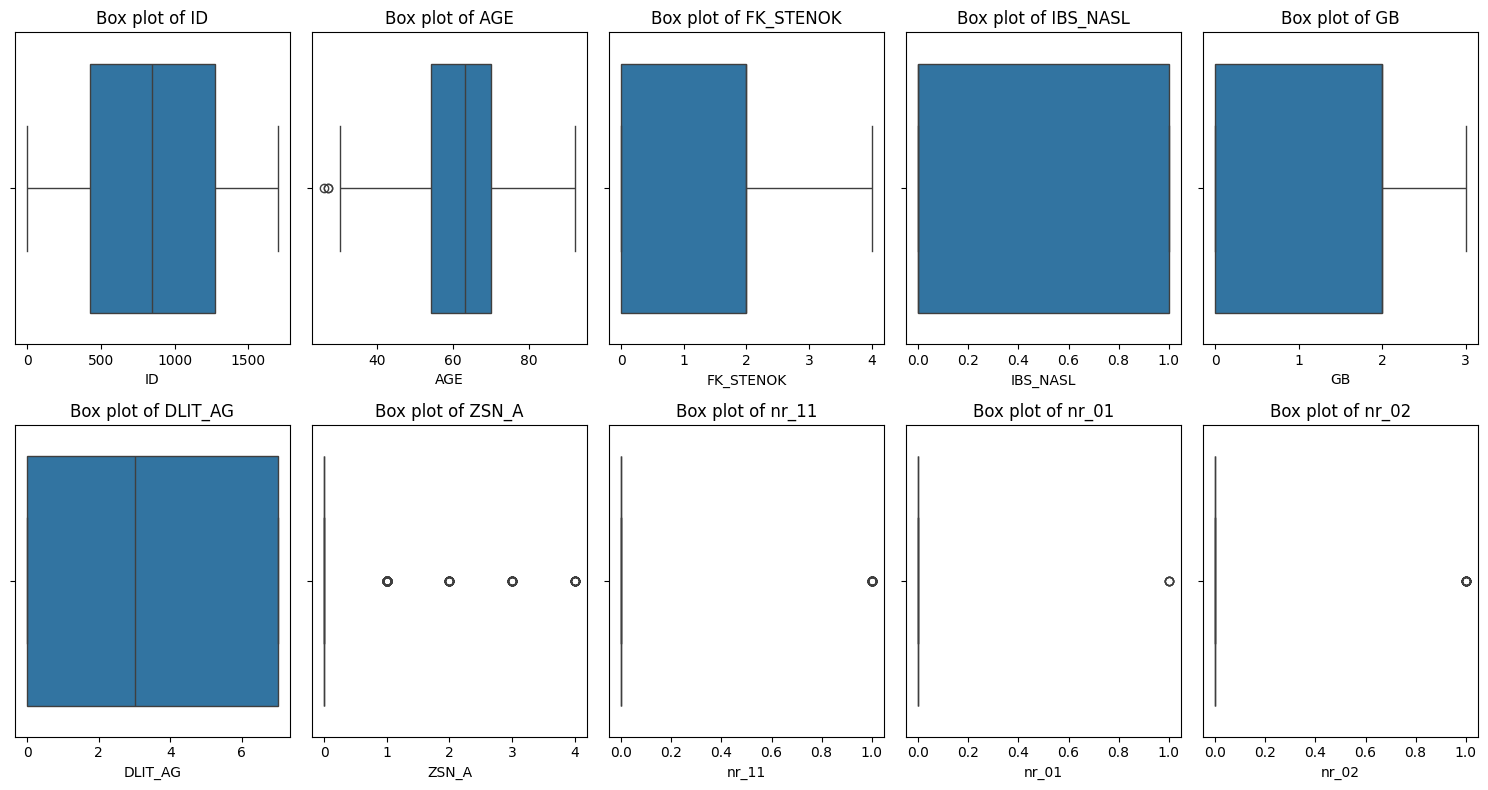

In [7]:
# Box plots to check outliers in numeric columns (same 10 columns)
plt.figure(figsize=(15, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 5, i)
    sns.boxplot(x=df[col])
    plt.title(f"Box plot of {col}")
plt.tight_layout()
plt.show()

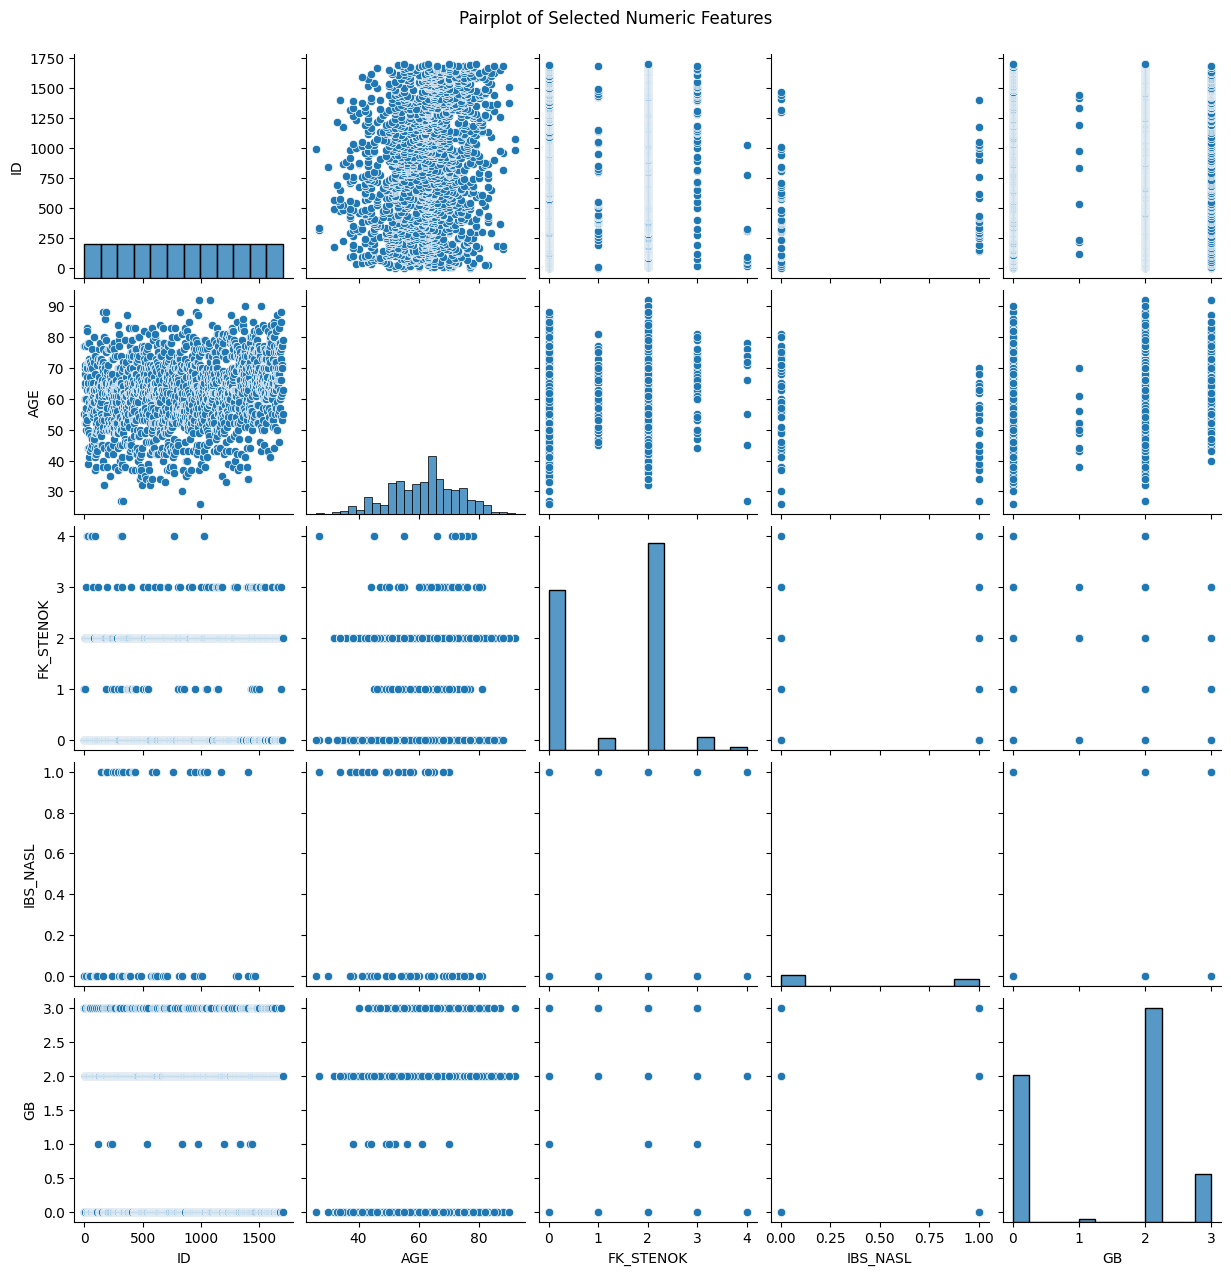

In [8]:
# Pairplot for some numeric columns to see relationships (limit to 5 for speed)
sns.pairplot(df[num_cols[:5]])
plt.suptitle("Pairplot of Selected Numeric Features", y=1.02)
plt.show()

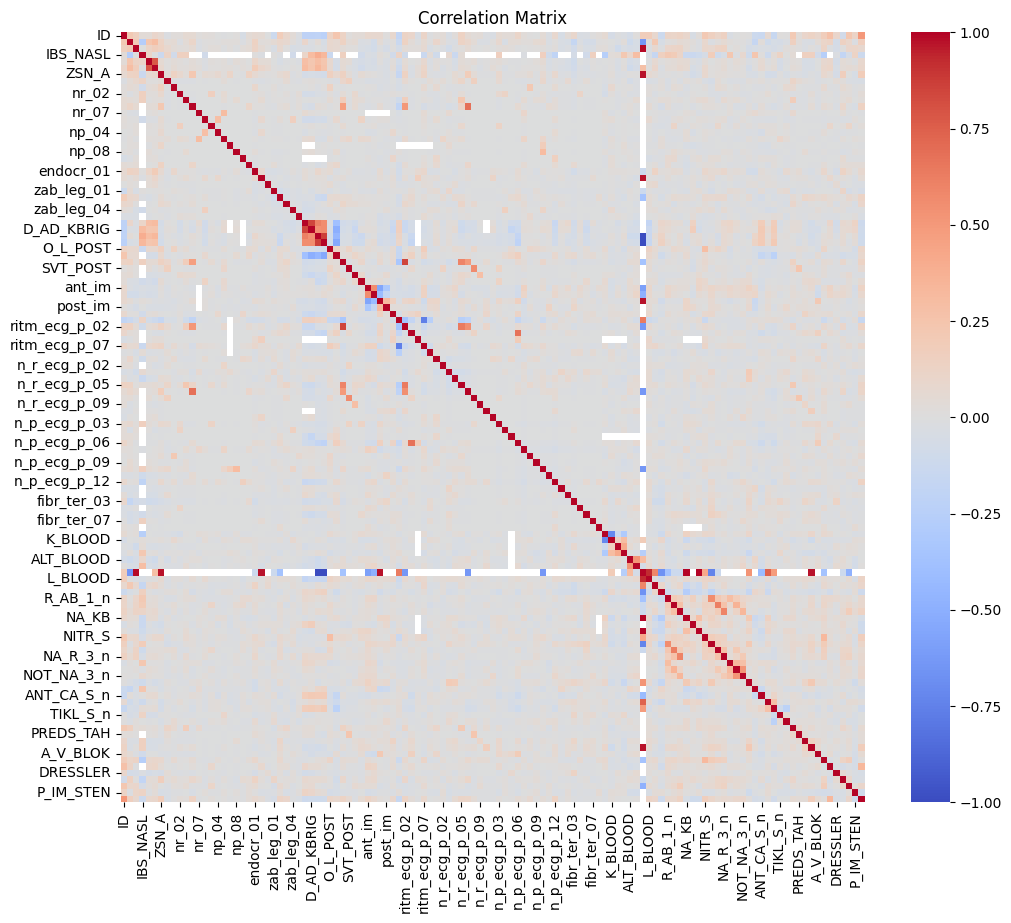

In [9]:
# Correlation matrix heatmap for numeric features
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Data Preprocessing

In [10]:
# Handle missing values
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

categorical_cols = ['SEX', 'INF_ANAM', 'STENOK_AN', 'IBS_POST', 'SIM_GIPERT']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
    df[col] = df[col].astype('category')

# Encode categorical variables using one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Assume target variable is 'LET_IS'
target = 'LET_IS'
X = df_encoded.drop(columns=[target, 'ID'])
y = df_encoded[target]

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("Preprocessing completed.")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print("Train class distribution:\n", y_train.value_counts(normalize=True))

Preprocessing completed.
Train shape: (1360, 130), Test shape: (340, 130)
Train class distribution:
 LET_IS
0    0.840441
1    0.064706
3    0.031618
6    0.016176
7    0.016176
4    0.013235
2    0.010294
5    0.007353
Name: proportion, dtype: float64


# Handle class imbalance with SMOTE

In [11]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Model selection and training

In [12]:
# Model selection and training
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
}

# Model evaluation

In [13]:
# Model evaluation
for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='weighted', zero_division=0))
    print("Recall:", recall_score(y_test, y_pred, average='weighted', zero_division=0))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted', zero_division=0))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))



--- Logistic Regression ---
Accuracy: 0.7823529411764706
Precision: 0.8706518332265345
Recall: 0.7823529411764706
F1 Score: 0.8217380861799721

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       286
           1       0.50      0.55      0.52        22
           2       0.15      0.50      0.24         4
           3       1.00      1.00      1.00        11
           4       0.09      0.20      0.12         5
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         5
           7       0.12      0.20      0.15         5

    accuracy                           0.78       340
   macro avg       0.35      0.41      0.37       340
weighted avg       0.87      0.78      0.82       340


--- Random Forest ---
Accuracy: 0.9205882352941176
Precision: 0.8912096417514375
Recall: 0.9205882352941176
F1 Score: 0.8986529571178066

Classification Report:
              preci

# Model Comparison Summary

In [14]:
# Create a list to store results
results = []

# Rerun models to collect performance metrics in a table
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    })

# Convert results to a DataFrame
summary_df = pd.DataFrame(results)

# Sort by F1 Score or Accuracy
summary_df = summary_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

# Display the summary
print("\nModel Comparison Summary:")
print(summary_df)



Model Comparison Summary:
                    Model  Accuracy  Precision    Recall  F1 Score
0       Gradient Boosting  0.923529   0.914919  0.923529  0.915217
1           Random Forest  0.920588   0.891210  0.920588  0.898653
2  Support Vector Machine  0.870588   0.821989  0.870588  0.840907
3     Logistic Regression  0.782353   0.870652  0.782353  0.821738
4     K-Nearest Neighbors  0.594118   0.844680  0.594118  0.686545
5             Naive Bayes  0.202941   0.761071  0.202941  0.294493


 Best Model: Gradient Boosting. It has the highest accuracy (92.9%), Performs well across most classes (especially the dominant class 0 and others like 1 and 3).


Plot Confusion Matrix for Best Model

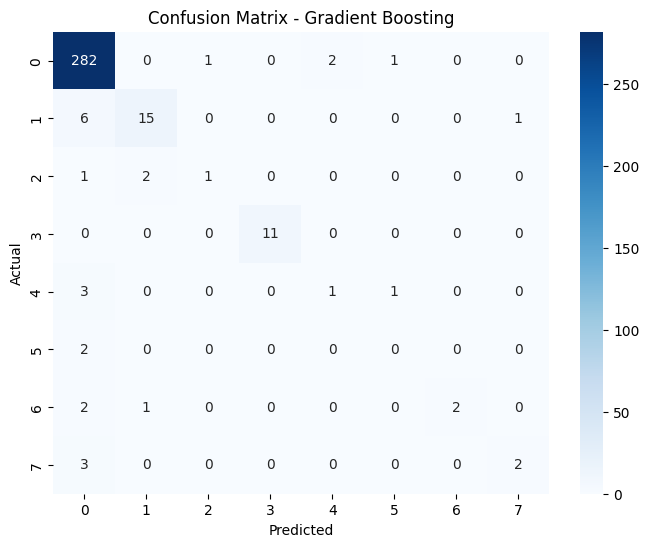

In [15]:
# Assuming Gradient Boosting is the best model
best_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
best_model.fit(X_train_res, y_train_res)
y_pred_best = best_model.predict(X_test)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Binarize test labels for multiclass ROC

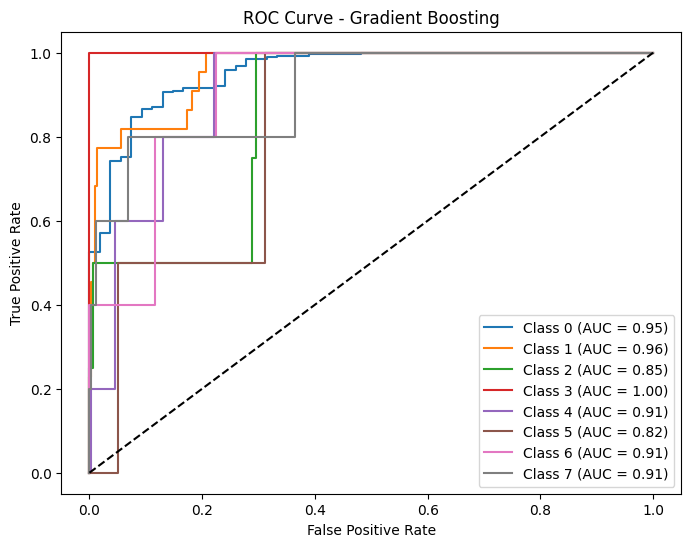

In [16]:
# Binarize test labels for multiclass ROC
classes = sorted(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Get prediction probabilities
y_score = best_model.predict_proba(X_test)

plt.figure(figsize=(8,6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend()
plt.show()


Save the Best Model

In [17]:
# Save the model
joblib.dump(best_model, "Myocardial_Infarction_Predicter_Gradient_Boosting_Model.pkl")
print("Model saved as 'Myocardial_Infarction_Predicter_Gradient_Boosting_Model.pkl'")

# Save the scaler
joblib.dump(scaler, "Scaler_Myocardial_Infarction.pkl")
print("Scaler saved as 'Scaler_Myocardial_Infarction.pkl'")


Model saved as 'gradient_boosting_model.pkl'
Scaler saved as 'scaler.pkl'
